<a href="https://colab.research.google.com/github/djliden/numerai/blob/main/notebooks/Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Previous iterations of this project attempted to reduce everything to a single command-line script that could read a configuration file, run the corresponding model or models, out output the results.

This notebook takes a different approach. It loads and uses some of the utiltiies for e.g. loading data, making submissions, computing metrics, and handling configurations, but the training loop should be defined fully in the notebook. This will allow for faster iteration and more transparent model comparison. Models to be consistently re-used can be repackaged to run from the command line if that would be beneficial.

## Imports and Setup

In [1]:
!git clone https://github.com/djliden/numerai.git
!pip install --upgrade python-dotenv numerapi dask
%cd numerai

Cloning into 'numerai'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (509/509), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 509 (delta 312), reused 274 (delta 123), pack-reused 0
Receiving objects: 100% (509/509), 340.91 KiB | 2.89 MiB/s, done.
Resolving deltas: 100% (312/312), done.
     |████████████████████████████████| 942kB 4.5MB/s 
     |████████████████████████████████| 112kB 27.3MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0
/content/numerai


In [2]:
import copy
import os
from pathlib import Path
if Path().resolve().name != 'numerai':
    os.chdir(Path().resolve().parent)

!pip install --upgrade -I git+https://github.com/djliden/config-nest.git

import confignest.confignest
from pathlib import Path
import pandas as pd
import numpy as np
import time
from importlib import import_module
import time
from tqdm import tqdm
import yaml

import src.utils.setup
import src.utils.cross_val
import src.utils.eval
import src.utils.metrics
import gc
np.random.seed(623)    

  Cloning https://github.com/djliden/config-nest.git to /tmp/pip-req-build-mo881680
  Running command git clone -q https://github.com/djliden/config-nest.git /tmp/pip-req-build-mo881680
     |████████████████████████████████| 645kB 5.2MB/s 
  Created wheel for confignest: filename=confignest-0.0.1-cp37-none-any.whl size=4507 sha256=02a330f2bc3d309922ef513e14ff6311380c214e2374ec8aac3afdf81d808ac5
  Stored in directory: /tmp/pip-ephem-wheel-cache-6p2y90fx/wheels/ed/fe/df/6fa309b808e0c5d4b33fea633815bd208a9e3bc87e28304f20
Successfully built confignest


## NumerAPI setup and Data Download

In [3]:
src.utils.setup.credential()
napi = src.utils.setup.init_numerapi()

round = napi.get_current_round()
train = Path(f"./input/numerai_dataset_{round}/numerai_training_data.csv")
tourn = Path(f"./input/numerai_dataset_{round}/numerai_tournament_data.csv")
processed = Path(f'./input/training_processed_{round}.csv')
processed_pkl = Path(f'./input/training_processed_{round}.pkl')
output = Path("./output/")

src.utils.setup.download_current(napi=napi)
training_data, feature_cols, target_cols = src.utils.setup.process_current(processed,
                                                           processed_pkl, train, tourn)

Loaded Numerai Public Key into Global Environment!
Loaded Numerai Secret Key into Global Environment!


input/numerai_dataset_258.zip: 100%|█████████▉| 398M/398M [00:24<00:00, 20.2MB/s]2021-04-08 22:24:28,736 INFO numerapi.base_api: unzipping file...
input/numerai_dataset_258.zip: 398MB [00:39, 20.2MB/s]                           

Processing training data...

Training Dataset Generated! Saving to file ...


## Initial Configuration Setup

In [4]:
default_config = Path("./src/config/default_config.yaml")
cfg = confignest.confignest.Config(default_config)
cfg

Config Object with Keys:
CV:
  GAP: 0
  TRAIN_START: 0
  TRAIN_STOP: null
  VAL_END: 210
  VAL_N_ERAS: 4
  VAL_START: 206
DATA:
  REFRESH: false
  SAVE_PROCESSED_TRAIN: true
EVAL:
  CHUNK_SIZE: 1000000
  SAVE_PREDS: true
  SUBMIT_PREDS: false
SYSTEM:
  DEBUG: false

# Model Definition
This involves two components: the "default" model configuration and the definition of the model itself. In this case, we'll look at a Lasso model (to continue exploring the unreasonably good effectiveness of these models).

In [5]:
# Model Configuration
mod_cfg = {'MODEL': {
    'mod': 'Lasso',
    'alpha': .0005
}}
cfg.update_config(mod_cfg)
cfg.MODEL

Config Object with Keys:
alpha: 0.0005
mod: Lasso

In [6]:
# Model Definition
import sklearn.linear_model
mod = getattr(sklearn.linear_model, cfg.MODEL.mod)(alpha=cfg.MODEL.alpha)

# Training Loop
Similarly, the training loop has (or can have) its own configuration. Though it might be more convenient to keep this outside the configuration. It depends.

In [7]:
cv_config = {'CV': {
    'TRAIN_STOP': 120,
    'VAL_START': 209
}}
cfg.update_config(cv_config)
cfg.CV

Config Object with Keys:
GAP: 0
TRAIN_START: 0
TRAIN_STOP: 120
VAL_END: 210
VAL_N_ERAS: 4
VAL_START: 209

In [8]:
# Sweep
from sklearn.model_selection import ParameterGrid
param_grid = {
    'alpha': np.linspace(.0001, .001, 5),
    'mod': ['Lasso'],
    'train_stop': np.arange(25, 132)    
}

In [9]:
era_split = src.utils.cross_val.EraCV(eras = training_data.era)

X, y, era = training_data[feature_cols], training_data.target, training_data.era
name = 'TEST'
logs = []
for params in ParameterGrid(param_grid):
    corrs = []
    sharpes = []
    cfg_update = {'MODEL': {'alpha': params['alpha'].item(),
                           'mod': params['mod']},
                 'RESULTS': {'mean_corr': None,
                            'mean_sharpe': None},
                 'CV': {'TRAIN_STOP':params['train_stop'].item()}}
    cfg.update_config(cfg_update)
    mod = getattr(sklearn.linear_model, cfg.MODEL.mod)(alpha=cfg.MODEL.alpha)   

    for valid_era in tqdm(range(208,209)):
        train, test = era_split.get_splits(valid_start = valid_era,
                                           valid_n_eras = 4,
                                           train_start = cfg.CV.TRAIN_START,
                                           train_stop = cfg.CV.TRAIN_STOP)
        mod.fit(X.iloc[train], y.iloc[train])
        val_preds = mod.predict(X.iloc[test])
        eval_df = pd.DataFrame({'prediction':val_preds,
                            'target':y.iloc[test],
                            'era':era.iloc[test]}).reset_index()
        corrs.append(src.utils.metrics.val_corr(eval_df))
        sharpes.append(src.utils.metrics.sharpe(eval_df))
    print(f'\nmodel: {mod.__class__.__name__}')
    if mod.__class__.__name__!="LinearRegression":
        print(f'alpha: {mod.alpha}')
    if mod.__class__.__name__=="ElasticNet":
        print(f'L1 Ratio: {mod.l1_ratio}')
    print(f'train stop: {cfg.CV.TRAIN_STOP}')
    print(f'mean validation corr: {np.array(corrs).mean()}')
    print(f'mean validation sharpe: {np.array(sharpes).mean()}')
    results = {'RESULTS': {'mean_corr': np.array(corrs).mean().item(),
                          'mean_sharpe': np.array(sharpes).mean().item()}
              }
    cfg.update_config(results)
    logs.append(copy.deepcopy(cfg.config))


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 25
mean validation corr: 0.0008642455229190497
mean validation sharpe: 0.02132967967098023



100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 26
mean validation corr: 0.0021485006793837847
mean validation sharpe: 0.05354602460769885



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 27
mean validation corr: 0.0003556931830714441
mean validation sharpe: 0.00919042893814813



100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 28
mean validation corr: 0.0012663277440892982
mean validation sharpe: 0.03291229272942421



100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 29
mean validation corr: 0.0005675890839057507
mean validation sharpe: 0.015160143373518955



100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 30
mean validation corr: 0.002426275310608234
mean validation sharpe: 0.05951983264223677



100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 31
mean validation corr: 0.0007765774670524285
mean validation sharpe: 0.018899917648136987



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 32
mean validation corr: 0.0013817583749474362
mean validation sharpe: 0.03253933643156772



100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 33
mean validation corr: 0.0023567132836472826
mean validation sharpe: 0.05498533597032796



100%|██████████| 1/1 [00:03<00:00,  3.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 34
mean validation corr: 0.0029103160404439447
mean validation sharpe: 0.07280837304510804



100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 35
mean validation corr: 0.002484105775501507
mean validation sharpe: 0.06517909980723498



100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 36
mean validation corr: 0.0034659905613519375
mean validation sharpe: 0.08903435171537188



100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 37
mean validation corr: 0.0035437315642392817
mean validation sharpe: 0.08229070837775151



100%|██████████| 1/1 [00:03<00:00,  3.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 38
mean validation corr: 0.0026653697836884083
mean validation sharpe: 0.0641684649732623



100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 39
mean validation corr: 0.003608655470907827
mean validation sharpe: 0.0867082277430618



100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 40
mean validation corr: 0.0022916021974798088
mean validation sharpe: 0.05779048104210449



100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 41
mean validation corr: 0.0014595812179043662
mean validation sharpe: 0.03894571343260078



100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 42
mean validation corr: 0.0017284712299475286
mean validation sharpe: 0.047968020501432354



100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 43
mean validation corr: 0.0008439358112685529
mean validation sharpe: 0.02224634317223394



100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 44
mean validation corr: 0.0016998557498441695
mean validation sharpe: 0.04390509878621877



100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 45
mean validation corr: 0.0022945966574472645
mean validation sharpe: 0.05654796938010011



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 46
mean validation corr: 0.0012982119984624833
mean validation sharpe: 0.033972940833696445



100%|██████████| 1/1 [00:05<00:00,  5.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 47
mean validation corr: 0.0020454985999369575
mean validation sharpe: 0.05395795749446915



100%|██████████| 1/1 [00:06<00:00,  6.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 48
mean validation corr: 0.004238125269086566
mean validation sharpe: 0.11395964437872405



100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 49
mean validation corr: 0.005424658043742795
mean validation sharpe: 0.14316754398109777



100%|██████████| 1/1 [00:05<00:00,  5.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 50
mean validation corr: 0.006222233946375574
mean validation sharpe: 0.1527333919600322



100%|██████████| 1/1 [00:05<00:00,  5.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 51
mean validation corr: 0.006417801304448764
mean validation sharpe: 0.14955572962078267



100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 52
mean validation corr: 0.006990357704402497
mean validation sharpe: 0.16898539740902482



100%|██████████| 1/1 [00:05<00:00,  5.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 53
mean validation corr: 0.006987881714181609
mean validation sharpe: 0.16484442710193978



100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 54
mean validation corr: 0.006720806009109605
mean validation sharpe: 0.14630770464407747



100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 55
mean validation corr: 0.005497978986243258
mean validation sharpe: 0.1191354763233436



100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 56
mean validation corr: 0.004609242763983546
mean validation sharpe: 0.09752610284199328



100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 57
mean validation corr: 0.0048046014232852995
mean validation sharpe: 0.10154017851314974



100%|██████████| 1/1 [00:05<00:00,  5.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 58
mean validation corr: 0.003767937955538562
mean validation sharpe: 0.08156784526645254



100%|██████████| 1/1 [00:05<00:00,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 59
mean validation corr: 0.00430239845444875
mean validation sharpe: 0.09441182187951588



100%|██████████| 1/1 [00:05<00:00,  5.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 60
mean validation corr: 0.004279841781371575
mean validation sharpe: 0.09936301035066468



100%|██████████| 1/1 [00:07<00:00,  7.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 61
mean validation corr: 0.004183343949336166
mean validation sharpe: 0.09824660096732252



100%|██████████| 1/1 [00:07<00:00,  7.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 62
mean validation corr: 0.002112575351473321
mean validation sharpe: 0.05047203226768501



100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 63
mean validation corr: 0.0027611338741211928
mean validation sharpe: 0.06272604976222967



100%|██████████| 1/1 [00:08<00:00,  8.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 64
mean validation corr: 0.0034150778504428974
mean validation sharpe: 0.07503363548970761



100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 65
mean validation corr: 0.002629693505672062
mean validation sharpe: 0.055617003899135264



100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 66
mean validation corr: 0.0015762442252181784
mean validation sharpe: 0.032418130634978184



100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 67
mean validation corr: 0.0028732807233188065
mean validation sharpe: 0.05838086299099014



100%|██████████| 1/1 [00:07<00:00,  7.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 68
mean validation corr: 0.00133966811313109
mean validation sharpe: 0.02777987285717661



100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 69
mean validation corr: -0.0024200461556761373
mean validation sharpe: -0.04894803685378866



100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 70
mean validation corr: -0.003492464136524388
mean validation sharpe: -0.07038494286242929



100%|██████████| 1/1 [00:06<00:00,  6.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 71
mean validation corr: -0.0027046387766018337
mean validation sharpe: -0.05456614575223572



100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 72
mean validation corr: -0.0010429466570727325
mean validation sharpe: -0.021375084174667734



100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 73
mean validation corr: -0.0022367986901154994
mean validation sharpe: -0.04762900041519315



100%|██████████| 1/1 [00:06<00:00,  6.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 74
mean validation corr: -0.000124344357833402
mean validation sharpe: -0.002815618320250231



100%|██████████| 1/1 [00:06<00:00,  6.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 75
mean validation corr: 0.0017571966196181649
mean validation sharpe: 0.04044227477313546



100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 76
mean validation corr: 0.002665935071101397
mean validation sharpe: 0.059529006472279274



100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 77
mean validation corr: 0.004006890610198887
mean validation sharpe: 0.0875404003559138



100%|██████████| 1/1 [00:07<00:00,  7.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 78
mean validation corr: 0.004340715480697078
mean validation sharpe: 0.09817158996106394



100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 79
mean validation corr: 0.004160402633621534
mean validation sharpe: 0.08953725787252073



100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 80
mean validation corr: 0.003218991956473901
mean validation sharpe: 0.07131133189051651



100%|██████████| 1/1 [00:09<00:00,  9.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 81
mean validation corr: 0.0047587103585851765
mean validation sharpe: 0.10870175765763174



100%|██████████| 1/1 [00:09<00:00,  9.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 82
mean validation corr: 0.0032365983705838625
mean validation sharpe: 0.07717534195410443



100%|██████████| 1/1 [00:07<00:00,  7.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 83
mean validation corr: 0.004767464457663141
mean validation sharpe: 0.11428046533800129



100%|██████████| 1/1 [00:08<00:00,  8.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 84
mean validation corr: 0.004013274620255242
mean validation sharpe: 0.10421152746192948



100%|██████████| 1/1 [00:08<00:00,  8.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 85
mean validation corr: 0.004834892795198633
mean validation sharpe: 0.12769154711436242



100%|██████████| 1/1 [00:08<00:00,  8.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 86
mean validation corr: 0.005026743591757922
mean validation sharpe: 0.13590161852333532



100%|██████████| 1/1 [00:08<00:00,  8.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 87
mean validation corr: 0.004824065659996079
mean validation sharpe: 0.13569175449789003



100%|██████████| 1/1 [00:08<00:00,  8.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 88
mean validation corr: 0.004764796155071456
mean validation sharpe: 0.13098487906517547



100%|██████████| 1/1 [00:07<00:00,  7.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 89
mean validation corr: 0.004523356889741788
mean validation sharpe: 0.12439107772173195



100%|██████████| 1/1 [00:08<00:00,  8.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 90
mean validation corr: 0.004601198087550806
mean validation sharpe: 0.12638443585607384



100%|██████████| 1/1 [00:10<00:00, 10.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 91
mean validation corr: 0.0053455217502524095
mean validation sharpe: 0.14796396810560516



100%|██████████| 1/1 [00:09<00:00,  9.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 92
mean validation corr: 0.005777242793181968
mean validation sharpe: 0.1504870984295127



100%|██████████| 1/1 [00:09<00:00,  9.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 93
mean validation corr: 0.005967527928011173
mean validation sharpe: 0.1504753357551482



100%|██████████| 1/1 [00:09<00:00,  9.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 94
mean validation corr: 0.006276448810335487
mean validation sharpe: 0.16188472673004675



100%|██████████| 1/1 [00:09<00:00,  9.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 95
mean validation corr: 0.0062682127287648284
mean validation sharpe: 0.1638600482155292



100%|██████████| 1/1 [00:08<00:00,  8.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 96
mean validation corr: 0.00681059910431614
mean validation sharpe: 0.17039421085735623



100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 97
mean validation corr: 0.006940491595948983
mean validation sharpe: 0.17182694583922808



100%|██████████| 1/1 [00:08<00:00,  8.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 98
mean validation corr: 0.007683791323191521
mean validation sharpe: 0.1921484724228322



100%|██████████| 1/1 [00:08<00:00,  8.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 99
mean validation corr: 0.006734431898834986
mean validation sharpe: 0.1659404058736883



100%|██████████| 1/1 [00:08<00:00,  8.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 100
mean validation corr: 0.00581212101582
mean validation sharpe: 0.14409177457502362



100%|██████████| 1/1 [00:09<00:00,  9.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 101
mean validation corr: 0.0051715919897280735
mean validation sharpe: 0.1283425586105846



100%|██████████| 1/1 [00:08<00:00,  8.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 102
mean validation corr: 0.005038724234276372
mean validation sharpe: 0.12511828813671455



100%|██████████| 1/1 [00:08<00:00,  8.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 103
mean validation corr: 0.004437519336063234
mean validation sharpe: 0.10655070081121744



100%|██████████| 1/1 [00:08<00:00,  8.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 104
mean validation corr: 0.00455234135644879
mean validation sharpe: 0.11193593942365837



100%|██████████| 1/1 [00:08<00:00,  8.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 105
mean validation corr: 0.005857566681147857
mean validation sharpe: 0.13768223341553784



100%|██████████| 1/1 [00:08<00:00,  8.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 106
mean validation corr: 0.005392296057488996
mean validation sharpe: 0.12854181248219568



100%|██████████| 1/1 [00:08<00:00,  8.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 107
mean validation corr: 0.004515159012651785
mean validation sharpe: 0.10840854904101875



100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 108
mean validation corr: 0.005008321845204208
mean validation sharpe: 0.11826079910862254



100%|██████████| 1/1 [00:12<00:00, 12.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 109
mean validation corr: 0.005645769212276478
mean validation sharpe: 0.13223471427629255



100%|██████████| 1/1 [00:12<00:00, 12.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 110
mean validation corr: 0.006006324253254702
mean validation sharpe: 0.14041430152600337



100%|██████████| 1/1 [00:13<00:00, 13.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 111
mean validation corr: 0.005093073852775345
mean validation sharpe: 0.1152867696474519



100%|██████████| 1/1 [00:13<00:00, 13.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 112
mean validation corr: 0.004897898552139174
mean validation sharpe: 0.1119156738355873



100%|██████████| 1/1 [00:13<00:00, 13.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 113
mean validation corr: 0.005274449426879721
mean validation sharpe: 0.11879991405863642



100%|██████████| 1/1 [00:14<00:00, 14.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 114
mean validation corr: 0.0036114521773904246
mean validation sharpe: 0.0793115015353196



100%|██████████| 1/1 [00:14<00:00, 14.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 115
mean validation corr: 0.0034255527450489966
mean validation sharpe: 0.07401037618859642



100%|██████████| 1/1 [00:14<00:00, 14.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 116
mean validation corr: 0.0029563227168916996
mean validation sharpe: 0.06473442531359602



100%|██████████| 1/1 [00:13<00:00, 13.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 117
mean validation corr: 0.0030951415454120775
mean validation sharpe: 0.06871345825762123



100%|██████████| 1/1 [00:12<00:00, 12.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 118
mean validation corr: 0.0034483032723107744
mean validation sharpe: 0.07683893281253928



100%|██████████| 1/1 [00:11<00:00, 11.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 119
mean validation corr: 0.00324446814961369
mean validation sharpe: 0.07484327878625852



100%|██████████| 1/1 [00:12<00:00, 12.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 120
mean validation corr: 0.0032369476608080476
mean validation sharpe: 0.07390241124969149



100%|██████████| 1/1 [00:11<00:00, 11.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 121
mean validation corr: 0.0035497601185062056
mean validation sharpe: 0.08131639512722777



100%|██████████| 1/1 [00:12<00:00, 12.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 122
mean validation corr: 0.0034938610699938918
mean validation sharpe: 0.07970734215218984



100%|██████████| 1/1 [00:12<00:00, 12.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 123
mean validation corr: 0.0038815861782074603
mean validation sharpe: 0.08624329468094241



100%|██████████| 1/1 [00:14<00:00, 14.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 124
mean validation corr: 0.004357283425333093
mean validation sharpe: 0.09746483420130267



100%|██████████| 1/1 [00:16<00:00, 16.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 125
mean validation corr: 0.004886792486380182
mean validation sharpe: 0.10699027277460477



100%|██████████| 1/1 [00:16<00:00, 16.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 126
mean validation corr: 0.004843933324300366
mean validation sharpe: 0.1057115773640674



100%|██████████| 1/1 [00:15<00:00, 15.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 127
mean validation corr: 0.00474295717593181
mean validation sharpe: 0.10334869696842083



100%|██████████| 1/1 [00:16<00:00, 16.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 128
mean validation corr: 0.005053402935064956
mean validation sharpe: 0.11082237067658322



100%|██████████| 1/1 [00:14<00:00, 14.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 129
mean validation corr: 0.004415674211947497
mean validation sharpe: 0.09943602064574306



100%|██████████| 1/1 [00:14<00:00, 14.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 130
mean validation corr: 0.004188203370985589
mean validation sharpe: 0.09416558945839881



100%|██████████| 1/1 [00:12<00:00, 12.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0001
train stop: 131
mean validation corr: 0.004202250806781235
mean validation sharpe: 0.0934607095286664



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 25
mean validation corr: 0.0017765078859431072
mean validation sharpe: 0.046788171345568404



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 26
mean validation corr: 0.003518773750449778
mean validation sharpe: 0.08987606175166724



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 27
mean validation corr: 0.0031556362264152614
mean validation sharpe: 0.08154301798154182



100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 28
mean validation corr: 0.003711840725688354
mean validation sharpe: 0.1000024384391554



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 29
mean validation corr: 0.002544586191137725
mean validation sharpe: 0.07233907755106882



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 30
mean validation corr: 0.006270936989789212
mean validation sharpe: 0.16694356261988239



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 31
mean validation corr: 0.004264638439657331
mean validation sharpe: 0.10863830429805602



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 32
mean validation corr: 0.0048735743647257326
mean validation sharpe: 0.1202690674073107



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 33
mean validation corr: 0.004038509299529161
mean validation sharpe: 0.09365920626667307



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 34
mean validation corr: 0.005261605741612406
mean validation sharpe: 0.1378882375493274



100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 35
mean validation corr: 0.0059420383010185
mean validation sharpe: 0.1565191687192427



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 36
mean validation corr: 0.00644907707288369
mean validation sharpe: 0.1715359840183102



100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 37
mean validation corr: 0.005680873986423553
mean validation sharpe: 0.14447679884543663



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 38
mean validation corr: 0.004333745969808183
mean validation sharpe: 0.1150612782358309



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 39
mean validation corr: 0.004241259105113963
mean validation sharpe: 0.11201951134635482



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 40
mean validation corr: 0.002863714229709262
mean validation sharpe: 0.07742392948838912



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 41
mean validation corr: 0.0013720328516949633
mean validation sharpe: 0.03686896168692946



100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 42
mean validation corr: 0.0021315009968466345
mean validation sharpe: 0.05861223953139103



100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 43
mean validation corr: 0.0032892762989504398
mean validation sharpe: 0.08670183889877855



100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 44
mean validation corr: 0.00407697484766506
mean validation sharpe: 0.1044594129654155



100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 45
mean validation corr: 0.006233656428336974
mean validation sharpe: 0.14867295837962408



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 46
mean validation corr: 0.0043458302603023875
mean validation sharpe: 0.1112551283695038



100%|██████████| 1/1 [00:03<00:00,  3.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 47
mean validation corr: 0.005543336815974223
mean validation sharpe: 0.13989690546258277



100%|██████████| 1/1 [00:03<00:00,  3.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 48
mean validation corr: 0.007476508656591545
mean validation sharpe: 0.1903813689549958



100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 49
mean validation corr: 0.008379889273589377
mean validation sharpe: 0.21580823595419232



100%|██████████| 1/1 [00:04<00:00,  4.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 50
mean validation corr: 0.008721129331099597
mean validation sharpe: 0.21028213946520607



100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 51
mean validation corr: 0.007445540797049722
mean validation sharpe: 0.16974170447813078



100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 52
mean validation corr: 0.00834247561016516
mean validation sharpe: 0.19279492390388772



100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 53
mean validation corr: 0.00824869562577392
mean validation sharpe: 0.19148471989220509



100%|██████████| 1/1 [00:04<00:00,  4.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 54
mean validation corr: 0.007984394251177397
mean validation sharpe: 0.1759005619748386



100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 55
mean validation corr: 0.007676304459537408
mean validation sharpe: 0.16478401834429487



100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 56
mean validation corr: 0.007001079672491393
mean validation sharpe: 0.14346562347026434



100%|██████████| 1/1 [00:04<00:00,  4.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 57
mean validation corr: 0.00765530999075551
mean validation sharpe: 0.15412674927915776



100%|██████████| 1/1 [00:04<00:00,  4.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 58
mean validation corr: 0.007054981421482288
mean validation sharpe: 0.14621598144206224



100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 59
mean validation corr: 0.008611414025374714
mean validation sharpe: 0.18285273221233417



100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 60
mean validation corr: 0.00808724536266141
mean validation sharpe: 0.17768424013976467



100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 61
mean validation corr: 0.008503350861729613
mean validation sharpe: 0.18430651733210637



100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 62
mean validation corr: 0.0055022717090475945
mean validation sharpe: 0.11872376785815064



100%|██████████| 1/1 [00:04<00:00,  4.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 63
mean validation corr: 0.00690390765115486
mean validation sharpe: 0.14429656641443375



100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 64
mean validation corr: 0.007878247746417334
mean validation sharpe: 0.16369444341077857



100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 65
mean validation corr: 0.00696844806524346
mean validation sharpe: 0.14098535742114315



100%|██████████| 1/1 [00:05<00:00,  5.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 66
mean validation corr: 0.006105507421900682
mean validation sharpe: 0.12021801001110737



100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 67
mean validation corr: 0.007535524484256656
mean validation sharpe: 0.14845386761089632



100%|██████████| 1/1 [00:05<00:00,  5.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 68
mean validation corr: 0.0055405207750895726
mean validation sharpe: 0.11016076781651517



100%|██████████| 1/1 [00:05<00:00,  5.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 69
mean validation corr: 0.0014079874744073219
mean validation sharpe: 0.026186187537917262



100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 70
mean validation corr: -9.906267622923279e-05
mean validation sharpe: -0.0018446612887839217



100%|██████████| 1/1 [00:04<00:00,  4.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 71
mean validation corr: 0.0013439190475750956
mean validation sharpe: 0.02484964750739286



100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 72
mean validation corr: 0.003801104263238493
mean validation sharpe: 0.07300884808092806



100%|██████████| 1/1 [00:05<00:00,  5.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 73
mean validation corr: 0.002065436189922141
mean validation sharpe: 0.041177073496311896



100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 74
mean validation corr: 0.004415957346036881
mean validation sharpe: 0.09407775730602899



100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 75
mean validation corr: 0.006388140848318255
mean validation sharpe: 0.13717971093940137



100%|██████████| 1/1 [00:05<00:00,  5.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 76
mean validation corr: 0.0067135887640188355
mean validation sharpe: 0.13837085228682625



100%|██████████| 1/1 [00:05<00:00,  5.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 77
mean validation corr: 0.007330462445380543
mean validation sharpe: 0.151734255110287



100%|██████████| 1/1 [00:05<00:00,  5.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 78
mean validation corr: 0.007261006815982917
mean validation sharpe: 0.15342624051855508



100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 79
mean validation corr: 0.00660521967874806
mean validation sharpe: 0.13299487625632908



100%|██████████| 1/1 [00:05<00:00,  5.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 80
mean validation corr: 0.0044371006629912255
mean validation sharpe: 0.0892066899365428



100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 81
mean validation corr: 0.005705767837231385
mean validation sharpe: 0.12081997824982757



100%|██████████| 1/1 [00:05<00:00,  5.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 82
mean validation corr: 0.0039550464778381825
mean validation sharpe: 0.08478208284477774



100%|██████████| 1/1 [00:05<00:00,  5.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 83
mean validation corr: 0.004967550585364992
mean validation sharpe: 0.10601978307216825



100%|██████████| 1/1 [00:05<00:00,  5.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 84
mean validation corr: 0.004198568181753992
mean validation sharpe: 0.09359290601279832



100%|██████████| 1/1 [00:05<00:00,  5.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 85
mean validation corr: 0.004657744722763653
mean validation sharpe: 0.105513228314093



100%|██████████| 1/1 [00:05<00:00,  5.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 86
mean validation corr: 0.005355538888526398
mean validation sharpe: 0.12297292428516993



100%|██████████| 1/1 [00:04<00:00,  4.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 87
mean validation corr: 0.004801273442549268
mean validation sharpe: 0.11156782833111557



100%|██████████| 1/1 [00:06<00:00,  6.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 88
mean validation corr: 0.005314265077059033
mean validation sharpe: 0.1194279107632315



100%|██████████| 1/1 [00:06<00:00,  6.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 89
mean validation corr: 0.004573126678575085
mean validation sharpe: 0.10134503321751456



100%|██████████| 1/1 [00:05<00:00,  5.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 90
mean validation corr: 0.004264008780900214
mean validation sharpe: 0.09421886859429664



100%|██████████| 1/1 [00:05<00:00,  5.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 91
mean validation corr: 0.0039234570180976275
mean validation sharpe: 0.08390521258491729



100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 92
mean validation corr: 0.004959000315818677
mean validation sharpe: 0.10463672159144084



100%|██████████| 1/1 [00:05<00:00,  5.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 93
mean validation corr: 0.005092449899185817
mean validation sharpe: 0.10461235962229641



100%|██████████| 1/1 [00:05<00:00,  5.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 94
mean validation corr: 0.006010349264642525
mean validation sharpe: 0.126532244599218



100%|██████████| 1/1 [00:05<00:00,  5.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 95
mean validation corr: 0.006919778403950333
mean validation sharpe: 0.1482734518019498



100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 96
mean validation corr: 0.00756349770486817
mean validation sharpe: 0.16097309732728066



100%|██████████| 1/1 [00:05<00:00,  5.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 97
mean validation corr: 0.007583675117064337
mean validation sharpe: 0.15989722268157708



100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 98
mean validation corr: 0.007631982224964204
mean validation sharpe: 0.16339893506782754



100%|██████████| 1/1 [00:05<00:00,  5.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 99
mean validation corr: 0.006867241365931203
mean validation sharpe: 0.14591948080608816



100%|██████████| 1/1 [00:06<00:00,  6.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 100
mean validation corr: 0.006228316909089312
mean validation sharpe: 0.13417671086892077



100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 101
mean validation corr: 0.005258184202728817
mean validation sharpe: 0.11444330949986972



100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 102
mean validation corr: 0.00545223621602749
mean validation sharpe: 0.11749035763066805



100%|██████████| 1/1 [00:06<00:00,  6.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 103
mean validation corr: 0.005277476037991521
mean validation sharpe: 0.10919352156141685



100%|██████████| 1/1 [00:06<00:00,  6.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 104
mean validation corr: 0.004527153524567101
mean validation sharpe: 0.09512582227011257



100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 105
mean validation corr: 0.0067261319527110505
mean validation sharpe: 0.133648698474359



100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 106
mean validation corr: 0.006549502882329113
mean validation sharpe: 0.1318246402797841



100%|██████████| 1/1 [00:06<00:00,  6.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 107
mean validation corr: 0.005719730044536259
mean validation sharpe: 0.11518413786737774



100%|██████████| 1/1 [00:06<00:00,  6.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 108
mean validation corr: 0.0063917264296433855
mean validation sharpe: 0.12772452701990022



100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 109
mean validation corr: 0.007460022801674808
mean validation sharpe: 0.15097226880993647



100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 110
mean validation corr: 0.007937542981594874
mean validation sharpe: 0.16434020537905317



100%|██████████| 1/1 [00:06<00:00,  6.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 111
mean validation corr: 0.00661892225857416
mean validation sharpe: 0.1336323228456004



100%|██████████| 1/1 [00:06<00:00,  6.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 112
mean validation corr: 0.006501328337231613
mean validation sharpe: 0.12910959268067598



100%|██████████| 1/1 [00:06<00:00,  6.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 113
mean validation corr: 0.007035304191138351
mean validation sharpe: 0.13604270438816635



100%|██████████| 1/1 [00:07<00:00,  7.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 114
mean validation corr: 0.005858802285038659
mean validation sharpe: 0.11050493908003114



100%|██████████| 1/1 [00:08<00:00,  8.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 115
mean validation corr: 0.005456993798633502
mean validation sharpe: 0.10186711544008059



100%|██████████| 1/1 [00:08<00:00,  8.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 116
mean validation corr: 0.004726478881003514
mean validation sharpe: 0.08920136376234107



100%|██████████| 1/1 [00:08<00:00,  8.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 117
mean validation corr: 0.0055794941582730725
mean validation sharpe: 0.10697037703909669



100%|██████████| 1/1 [00:08<00:00,  8.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 118
mean validation corr: 0.0057788686435978846
mean validation sharpe: 0.11110060778840358



100%|██████████| 1/1 [00:08<00:00,  8.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 119
mean validation corr: 0.00599284848152464
mean validation sharpe: 0.11777562049969957



100%|██████████| 1/1 [00:08<00:00,  8.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 120
mean validation corr: 0.0059764515349355896
mean validation sharpe: 0.11921272925731165



100%|██████████| 1/1 [00:08<00:00,  8.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 121
mean validation corr: 0.005676820434239435
mean validation sharpe: 0.11376758144957992



100%|██████████| 1/1 [00:09<00:00,  9.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 122
mean validation corr: 0.005182165527801531
mean validation sharpe: 0.1055169224259337



100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 123
mean validation corr: 0.005457211537321304
mean validation sharpe: 0.10952971131757723



100%|██████████| 1/1 [00:09<00:00,  9.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 124
mean validation corr: 0.005978126779949642
mean validation sharpe: 0.1226066836943918



100%|██████████| 1/1 [00:09<00:00,  9.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 125
mean validation corr: 0.00641256683766883
mean validation sharpe: 0.12810760206104632



100%|██████████| 1/1 [00:08<00:00,  8.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 126
mean validation corr: 0.006520050891993276
mean validation sharpe: 0.13070081662188884



100%|██████████| 1/1 [00:09<00:00,  9.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 127
mean validation corr: 0.006146687234614699
mean validation sharpe: 0.12119820998599685



100%|██████████| 1/1 [00:09<00:00,  9.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 128
mean validation corr: 0.0060017428479286206
mean validation sharpe: 0.11886113130318529



100%|██████████| 1/1 [00:10<00:00, 10.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 129
mean validation corr: 0.005822982959023502
mean validation sharpe: 0.11869268880272348



100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 130
mean validation corr: 0.005814168483777766
mean validation sharpe: 0.11861759994489286



100%|██████████| 1/1 [00:09<00:00,  9.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.000325
train stop: 131
mean validation corr: 0.0055138425789865685
mean validation sharpe: 0.11101628215642804



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 25
mean validation corr: 0.004163993992436606
mean validation sharpe: 0.10374513178449021



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 26
mean validation corr: 0.004530807080323778
mean validation sharpe: 0.1096732759999967



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 27
mean validation corr: 0.0034624168460710737
mean validation sharpe: 0.08800022760095783



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 28
mean validation corr: 0.003882578494530324
mean validation sharpe: 0.09985868457634689



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 29
mean validation corr: 0.003720677699758373
mean validation sharpe: 0.10329028146775275



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 30
mean validation corr: 0.006800059485084425
mean validation sharpe: 0.18246401699157727



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 31
mean validation corr: 0.005581685883299808
mean validation sharpe: 0.142756931829306



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 32
mean validation corr: 0.006929835918109192
mean validation sharpe: 0.17570856835501852



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 33
mean validation corr: 0.005935597767395684
mean validation sharpe: 0.15042835240614746



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 34
mean validation corr: 0.007099241545193587
mean validation sharpe: 0.18479973372471592



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 35
mean validation corr: 0.008184500962395135
mean validation sharpe: 0.2050799648916502



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 36
mean validation corr: 0.008069820304380082
mean validation sharpe: 0.2044151434741154



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 37
mean validation corr: 0.008179729847797301
mean validation sharpe: 0.20902448281247996



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 38
mean validation corr: 0.006858832262829184
mean validation sharpe: 0.1776030986204301



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 39
mean validation corr: 0.006717239893233876
mean validation sharpe: 0.17706341590649843



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 40
mean validation corr: 0.006364109814907121
mean validation sharpe: 0.1679894954688978



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 41
mean validation corr: 0.005585831028577301
mean validation sharpe: 0.14326407669480282



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 42
mean validation corr: 0.006600103409808182
mean validation sharpe: 0.16700841516878664



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 43
mean validation corr: 0.006476185384473369
mean validation sharpe: 0.16099513310321972



100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 44
mean validation corr: 0.006944659824337845
mean validation sharpe: 0.168942445071659



100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 45
mean validation corr: 0.00769888965566398
mean validation sharpe: 0.17890595398211423



100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 46
mean validation corr: 0.006497835677977145
mean validation sharpe: 0.15914960651107604



100%|██████████| 1/1 [00:03<00:00,  3.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 47
mean validation corr: 0.007516201139314024
mean validation sharpe: 0.17973061560941647



100%|██████████| 1/1 [00:02<00:00,  3.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 48
mean validation corr: 0.00905776370284749
mean validation sharpe: 0.2195765475715872



100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 49
mean validation corr: 0.010254810547990593
mean validation sharpe: 0.25889819118273766



100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 50
mean validation corr: 0.010776041128449753
mean validation sharpe: 0.26562163041344056



100%|██████████| 1/1 [00:03<00:00,  3.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 51
mean validation corr: 0.010030201559044369
mean validation sharpe: 0.23216716167825385



100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 52
mean validation corr: 0.010708524301072728
mean validation sharpe: 0.253687859621184



100%|██████████| 1/1 [00:03<00:00,  3.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 53
mean validation corr: 0.010674543646861462
mean validation sharpe: 0.2618981432632861



100%|██████████| 1/1 [00:03<00:00,  3.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 54
mean validation corr: 0.011251976903501992
mean validation sharpe: 0.2525815760145075



100%|██████████| 1/1 [00:03<00:00,  3.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 55
mean validation corr: 0.009751311163249144
mean validation sharpe: 0.21271131258415304



100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 56
mean validation corr: 0.00923311271058509
mean validation sharpe: 0.19020049202373057



100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 57
mean validation corr: 0.009431659174775502
mean validation sharpe: 0.1913390188227185



100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 58
mean validation corr: 0.008792974326745459
mean validation sharpe: 0.18446895425194798



100%|██████████| 1/1 [00:04<00:00,  4.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 59
mean validation corr: 0.010073636467448794
mean validation sharpe: 0.2176356731947983



100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 60
mean validation corr: 0.00885618594798502
mean validation sharpe: 0.19446177734989284



100%|██████████| 1/1 [00:04<00:00,  4.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 61
mean validation corr: 0.010482796974262453
mean validation sharpe: 0.22476760568555637



100%|██████████| 1/1 [00:05<00:00,  5.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 62
mean validation corr: 0.008238527558816636
mean validation sharpe: 0.17718508317138115



100%|██████████| 1/1 [00:05<00:00,  5.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 63
mean validation corr: 0.009517700681282857
mean validation sharpe: 0.20105077771827987



100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 64
mean validation corr: 0.009520398770148516
mean validation sharpe: 0.20332138295628835



100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 65
mean validation corr: 0.00875827089223736
mean validation sharpe: 0.18711591747919779



100%|██████████| 1/1 [00:06<00:00,  6.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 66
mean validation corr: 0.007440867139085925
mean validation sharpe: 0.15232607985841676



100%|██████████| 1/1 [00:04<00:00,  4.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 67
mean validation corr: 0.007186530002918429
mean validation sharpe: 0.14422804207085727



100%|██████████| 1/1 [00:04<00:00,  4.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 68
mean validation corr: 0.005923352002413819
mean validation sharpe: 0.11780689769330421



100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 69
mean validation corr: 0.0033655231199672987
mean validation sharpe: 0.06515536711681488



100%|██████████| 1/1 [00:04<00:00,  4.34s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 70
mean validation corr: 0.0025118377119047047
mean validation sharpe: 0.04855046235111439



100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 71
mean validation corr: 0.0027930751805313667
mean validation sharpe: 0.05456721135200235



100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 72
mean validation corr: 0.0051573210174891745
mean validation sharpe: 0.10405939434251105



100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 73
mean validation corr: 0.004233581123878713
mean validation sharpe: 0.09136775206871287



100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 74
mean validation corr: 0.005762029600262428
mean validation sharpe: 0.127062528708649



100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 75
mean validation corr: 0.007716992326086955
mean validation sharpe: 0.1686912999735474



100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 76
mean validation corr: 0.008203812623821784
mean validation sharpe: 0.17810142040975438



100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 77
mean validation corr: 0.008202469109362263
mean validation sharpe: 0.17224565850649967



100%|██████████| 1/1 [00:04<00:00,  4.34s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 78
mean validation corr: 0.008952645644486681
mean validation sharpe: 0.19218590892902188



100%|██████████| 1/1 [00:04<00:00,  5.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 79
mean validation corr: 0.00814873636131125
mean validation sharpe: 0.1687816372889137



100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 80
mean validation corr: 0.006592651442243297
mean validation sharpe: 0.13473876422459485



100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 81
mean validation corr: 0.008089407157122934
mean validation sharpe: 0.1715368437656774



100%|██████████| 1/1 [00:04<00:00,  4.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 82
mean validation corr: 0.005290193695216921
mean validation sharpe: 0.11139774257789065



100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 83
mean validation corr: 0.006306867863459808
mean validation sharpe: 0.1335182584199767



100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 84
mean validation corr: 0.006485452126833638
mean validation sharpe: 0.1396268952490701



100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 85
mean validation corr: 0.006580019120879094
mean validation sharpe: 0.14145880533358887



100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 86
mean validation corr: 0.007083716340925795
mean validation sharpe: 0.1577510446647963



100%|██████████| 1/1 [00:04<00:00,  4.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 87
mean validation corr: 0.006348093494967242
mean validation sharpe: 0.1384404236873765



100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 88
mean validation corr: 0.007540523878784478
mean validation sharpe: 0.16222490180891558



100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 89
mean validation corr: 0.005492625896825946
mean validation sharpe: 0.11367434432206243



100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 90
mean validation corr: 0.004340304105159816
mean validation sharpe: 0.08706918865756129



100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 91
mean validation corr: 0.004383029693790508
mean validation sharpe: 0.08614402853376137



100%|██████████| 1/1 [00:04<00:00,  4.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 92
mean validation corr: 0.004648476357894268
mean validation sharpe: 0.09019162405441437



100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 93
mean validation corr: 0.004804130491348568
mean validation sharpe: 0.0913040985002437



100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 94
mean validation corr: 0.0051447725609690236
mean validation sharpe: 0.10017718204271922



100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 95
mean validation corr: 0.004872922178734661
mean validation sharpe: 0.09422466496374408



100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 96
mean validation corr: 0.005357835424692165
mean validation sharpe: 0.1068886998660447



100%|██████████| 1/1 [00:05<00:00,  5.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 97
mean validation corr: 0.005415449615211128
mean validation sharpe: 0.1090788081581626



100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 98
mean validation corr: 0.005219960991929727
mean validation sharpe: 0.10404526615466823



100%|██████████| 1/1 [00:05<00:00,  5.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 99
mean validation corr: 0.004754195021416323
mean validation sharpe: 0.09581610612647971



100%|██████████| 1/1 [00:05<00:00,  5.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 100
mean validation corr: 0.003314576997284999
mean validation sharpe: 0.06726864064946714



100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 101
mean validation corr: 0.002145070698160032
mean validation sharpe: 0.043089106173762236



100%|██████████| 1/1 [00:05<00:00,  5.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 102
mean validation corr: 0.0036894885968858683
mean validation sharpe: 0.07550927338281906



100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 103
mean validation corr: 0.003878185506330706
mean validation sharpe: 0.07759748429231002



100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 104
mean validation corr: 0.003048244711447561
mean validation sharpe: 0.06272914792437191



100%|██████████| 1/1 [00:05<00:00,  5.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 105
mean validation corr: 0.006457209649914163
mean validation sharpe: 0.1256818638495129



100%|██████████| 1/1 [00:05<00:00,  5.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 106
mean validation corr: 0.006648597772739262
mean validation sharpe: 0.13132353808575403



100%|██████████| 1/1 [00:05<00:00,  5.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 107
mean validation corr: 0.006007072986227879
mean validation sharpe: 0.11881529343259653



100%|██████████| 1/1 [00:05<00:00,  5.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 108
mean validation corr: 0.006690845471526914
mean validation sharpe: 0.13098029271517478



100%|██████████| 1/1 [00:05<00:00,  5.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 109
mean validation corr: 0.008284017499529487
mean validation sharpe: 0.16481928127697973



100%|██████████| 1/1 [00:05<00:00,  5.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 110
mean validation corr: 0.008366951728392313
mean validation sharpe: 0.16845323849233618



100%|██████████| 1/1 [00:06<00:00,  6.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 111
mean validation corr: 0.007916245370693391
mean validation sharpe: 0.157745731258363



100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 112
mean validation corr: 0.006424606879795385
mean validation sharpe: 0.12664637929536074



100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 113
mean validation corr: 0.006841790321797405
mean validation sharpe: 0.1330010850680013



100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 114
mean validation corr: 0.006156669118917471
mean validation sharpe: 0.11971024313402655



100%|██████████| 1/1 [00:06<00:00,  6.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 115
mean validation corr: 0.005892874928545918
mean validation sharpe: 0.11295800667569265



100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 116
mean validation corr: 0.005501099231930165
mean validation sharpe: 0.10815600277960567



100%|██████████| 1/1 [00:06<00:00,  6.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 117
mean validation corr: 0.006644781314291219
mean validation sharpe: 0.1301031898695451



100%|██████████| 1/1 [00:06<00:00,  6.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 118
mean validation corr: 0.005954474335904229
mean validation sharpe: 0.11751293429785195



100%|██████████| 1/1 [00:06<00:00,  6.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 119
mean validation corr: 0.005733179186574329
mean validation sharpe: 0.11415098891036872



100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 120
mean validation corr: 0.006301707873960923
mean validation sharpe: 0.12616049900282128



100%|██████████| 1/1 [00:07<00:00,  7.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 121
mean validation corr: 0.005857299770679376
mean validation sharpe: 0.11698495319778086



100%|██████████| 1/1 [00:09<00:00,  9.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 122
mean validation corr: 0.00472301544507887
mean validation sharpe: 0.09394213798082326



100%|██████████| 1/1 [00:08<00:00,  8.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 123
mean validation corr: 0.004906855478590155
mean validation sharpe: 0.0980221625925863



100%|██████████| 1/1 [00:08<00:00,  8.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 124
mean validation corr: 0.005484750652236619
mean validation sharpe: 0.11171711577069904



100%|██████████| 1/1 [00:08<00:00,  8.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 125
mean validation corr: 0.005650289399767472
mean validation sharpe: 0.11306349483312153



100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 126
mean validation corr: 0.005459493107899595
mean validation sharpe: 0.10870351753536787



100%|██████████| 1/1 [00:06<00:00,  6.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 127
mean validation corr: 0.004724694177200294
mean validation sharpe: 0.0946516476866047



100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 128
mean validation corr: 0.004821105647567783
mean validation sharpe: 0.09831527158631749



100%|██████████| 1/1 [00:07<00:00,  7.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 129
mean validation corr: 0.004157964506477459
mean validation sharpe: 0.08865340171166758



100%|██████████| 1/1 [00:08<00:00,  8.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 130
mean validation corr: 0.004155961047932309
mean validation sharpe: 0.09013123327179824



100%|██████████| 1/1 [00:09<00:00,  9.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.00055
train stop: 131
mean validation corr: 0.0027777257990895723
mean validation sharpe: 0.05905801595146438



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 25
mean validation corr: 0.005312750631045875
mean validation sharpe: 0.14637565599272379



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 26
mean validation corr: 0.0038314833834937907
mean validation sharpe: 0.10775905266206459



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 27
mean validation corr: 0.0021686696092738447
mean validation sharpe: 0.06330708417496786



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 28
mean validation corr: 0.003460188255545957
mean validation sharpe: 0.10132270246189756



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 29
mean validation corr: 0.0038827215500066535
mean validation sharpe: 0.12198777276835747



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 30
mean validation corr: 0.004791803072127417
mean validation sharpe: 0.1419485386633389



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 31
mean validation corr: 0.005838144206655449
mean validation sharpe: 0.16342842445696829



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 32
mean validation corr: 0.005601714973008295
mean validation sharpe: 0.1606087527578192



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 33
mean validation corr: 0.006195300651326383
mean validation sharpe: 0.1779960396868562



100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 34
mean validation corr: 0.00610420890846507
mean validation sharpe: 0.17035565121364657



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 35
mean validation corr: 0.007041434567898416
mean validation sharpe: 0.19463161384466543



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 36
mean validation corr: 0.006982560751658144
mean validation sharpe: 0.1941900644274907



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 37
mean validation corr: 0.007274847898712963
mean validation sharpe: 0.20084503756247704



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 38
mean validation corr: 0.006396520835065679
mean validation sharpe: 0.18041152685609907



100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 39
mean validation corr: 0.006202194835091718
mean validation sharpe: 0.1846647758720189



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 40
mean validation corr: 0.006965436104314275
mean validation sharpe: 0.2090939297174645



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 41
mean validation corr: 0.006857107092612491
mean validation sharpe: 0.19957747264144118



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 42
mean validation corr: 0.006857824049394128
mean validation sharpe: 0.19297424828277812



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 43
mean validation corr: 0.00739314935860844
mean validation sharpe: 0.2015398613319676



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 44
mean validation corr: 0.0067041151098729355
mean validation sharpe: 0.1801851757353571



100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 45
mean validation corr: 0.005545071825361009
mean validation sharpe: 0.14290375423036106



100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 46
mean validation corr: 0.005631111431082475
mean validation sharpe: 0.1504296281655238



100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 47
mean validation corr: 0.0058973084879790656
mean validation sharpe: 0.1511814972693586



100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 48
mean validation corr: 0.007012970168431181
mean validation sharpe: 0.17767808995429088



100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 49
mean validation corr: 0.0078031936599204195
mean validation sharpe: 0.20449092489473727



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 50
mean validation corr: 0.008497008812076955
mean validation sharpe: 0.23640862494924117



100%|██████████| 1/1 [00:03<00:00,  3.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 51
mean validation corr: 0.008133614771902855
mean validation sharpe: 0.2200917198887535



100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 52
mean validation corr: 0.008379906197019778
mean validation sharpe: 0.2232310116072505



100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 53
mean validation corr: 0.009444578831992895
mean validation sharpe: 0.2585008550573508



100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 54
mean validation corr: 0.00958982651912197
mean validation sharpe: 0.24461059990153367



100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 55
mean validation corr: 0.008815425643260086
mean validation sharpe: 0.21310019916310174



100%|██████████| 1/1 [00:03<00:00,  3.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 56
mean validation corr: 0.008538744718890406
mean validation sharpe: 0.19031843613557622



100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 57
mean validation corr: 0.00753530792495008
mean validation sharpe: 0.15842325528504478



100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 58
mean validation corr: 0.007247402343088325
mean validation sharpe: 0.15324859239224772



100%|██████████| 1/1 [00:04<00:00,  4.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 59
mean validation corr: 0.008591815599995379
mean validation sharpe: 0.1808929419118816



100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 60
mean validation corr: 0.007371279504484357
mean validation sharpe: 0.1615902234529425



100%|██████████| 1/1 [00:03<00:00,  3.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 61
mean validation corr: 0.008547311222519146
mean validation sharpe: 0.1871284946679105



100%|██████████| 1/1 [00:03<00:00,  3.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 62
mean validation corr: 0.006462421478711093
mean validation sharpe: 0.14094759559058068



100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 63
mean validation corr: 0.0066647254107708425
mean validation sharpe: 0.147185259396685



100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 64
mean validation corr: 0.00723312681537212
mean validation sharpe: 0.1655461399018686



100%|██████████| 1/1 [00:03<00:00,  3.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 65
mean validation corr: 0.007259544050289765
mean validation sharpe: 0.16822080251023702



100%|██████████| 1/1 [00:03<00:00,  3.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 66
mean validation corr: 0.0067255181663054
mean validation sharpe: 0.14604224275822775



100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 67
mean validation corr: 0.0058393407328653345
mean validation sharpe: 0.12629175814228086



100%|██████████| 1/1 [00:03<00:00,  3.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 68
mean validation corr: 0.00448742521951488
mean validation sharpe: 0.0965370111256042



100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 69
mean validation corr: 0.002958994422507806
mean validation sharpe: 0.06228594764246674



100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 70
mean validation corr: 0.0025607865549753493
mean validation sharpe: 0.05345159426485209



100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 71
mean validation corr: 0.0034011020922027624
mean validation sharpe: 0.07057953753414764



100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 72
mean validation corr: 0.004149180015923411
mean validation sharpe: 0.09039018441162966



100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 73
mean validation corr: 0.0024350704929723965
mean validation sharpe: 0.05536639296496128



100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 74
mean validation corr: 0.002989333307673694
mean validation sharpe: 0.07183209219076477



100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 75
mean validation corr: 0.0037846751047190402
mean validation sharpe: 0.08798775512177874



100%|██████████| 1/1 [00:04<00:00,  4.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 76
mean validation corr: 0.004719656125735199
mean validation sharpe: 0.11402499852915775



100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 77
mean validation corr: 0.004671015276456282
mean validation sharpe: 0.10562008887051241



100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 78
mean validation corr: 0.0034196700256953934
mean validation sharpe: 0.08219886400019191



100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 79
mean validation corr: 0.0030557585077625737
mean validation sharpe: 0.07259096204099316



100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 80
mean validation corr: 0.0025775175749741808
mean validation sharpe: 0.06387082756167796



100%|██████████| 1/1 [00:04<00:00,  4.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 81
mean validation corr: 0.004317343415873661
mean validation sharpe: 0.1062093615375973



100%|██████████| 1/1 [00:04<00:00,  4.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 82
mean validation corr: 0.0037834445313147946
mean validation sharpe: 0.09044745989401544



100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 83
mean validation corr: 0.004526230030263957
mean validation sharpe: 0.10756077696410196



100%|██████████| 1/1 [00:04<00:00,  4.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 84
mean validation corr: 0.005648025622046565
mean validation sharpe: 0.13054793345795346



100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 85
mean validation corr: 0.005904762221990237
mean validation sharpe: 0.13324279015272852



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 86
mean validation corr: 0.004606441090880127
mean validation sharpe: 0.10346808448166782



100%|██████████| 1/1 [00:04<00:00,  4.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 87
mean validation corr: 0.0038453608267240797
mean validation sharpe: 0.08731570550606722



100%|██████████| 1/1 [00:04<00:00,  4.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 88
mean validation corr: 0.003301782430106856
mean validation sharpe: 0.07593928586653555



100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 89
mean validation corr: 0.0028665233986296303
mean validation sharpe: 0.0652086331555825



100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 90
mean validation corr: 0.0032724256442475848
mean validation sharpe: 0.07065746720469446



100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 91
mean validation corr: 0.004305441689655689
mean validation sharpe: 0.0929932227603402



100%|██████████| 1/1 [00:04<00:00,  4.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 92
mean validation corr: 0.0030850614313928763
mean validation sharpe: 0.06459985109666322



100%|██████████| 1/1 [00:05<00:00,  5.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 93
mean validation corr: 0.0026042130164198214
mean validation sharpe: 0.053474862892028185



100%|██████████| 1/1 [00:05<00:00,  5.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 94
mean validation corr: 0.002095816535038937
mean validation sharpe: 0.04512225765905358



100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 95
mean validation corr: 0.0015439597842851135
mean validation sharpe: 0.03329946797779413



100%|██████████| 1/1 [00:07<00:00,  7.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 96
mean validation corr: 0.0017973598574551261
mean validation sharpe: 0.03966738086541037



100%|██████████| 1/1 [00:05<00:00,  5.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 97
mean validation corr: 0.0006996974179720658
mean validation sharpe: 0.015702421133227396



100%|██████████| 1/1 [00:05<00:00,  5.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 98
mean validation corr: -0.0002546232413141829
mean validation sharpe: -0.005544368398181452



100%|██████████| 1/1 [00:05<00:00,  5.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 99
mean validation corr: -0.00021724354963191007
mean validation sharpe: -0.004817216174009397



100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 100
mean validation corr: -0.0005095618345149974
mean validation sharpe: -0.011265441853374846



100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 101
mean validation corr: -0.0009298516967704146
mean validation sharpe: -0.020178980513931712



100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 102
mean validation corr: -0.0004358588933405204
mean validation sharpe: -0.010263265652060231



100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 103
mean validation corr: 3.510365770641871e-05
mean validation sharpe: 0.0008197086262277169



100%|██████████| 1/1 [00:03<00:00,  3.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 104
mean validation corr: -0.0006350479879549988
mean validation sharpe: -0.016092958200514824



100%|██████████| 1/1 [00:03<00:00,  3.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 105
mean validation corr: 0.00035661148037275867
mean validation sharpe: 0.008238843683433155



100%|██████████| 1/1 [00:03<00:00,  3.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 106
mean validation corr: 0.0008324475694419086
mean validation sharpe: 0.020415455779100613



100%|██████████| 1/1 [00:03<00:00,  3.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 107
mean validation corr: 0.0007258274263407891
mean validation sharpe: 0.018631865971613402



100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 108
mean validation corr: 0.00033297659821847
mean validation sharpe: 0.008343739332343128



100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 109
mean validation corr: 0.0011407547219332015
mean validation sharpe: 0.02850059230808892



100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 110
mean validation corr: 0.0014408877130327562
mean validation sharpe: 0.037610066011164525



100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 111
mean validation corr: 0.0019260070082491119
mean validation sharpe: 0.048815994550298225



100%|██████████| 1/1 [00:04<00:00,  4.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 112
mean validation corr: 0.0016972768071722745
mean validation sharpe: 0.041605871060188065



100%|██████████| 1/1 [00:05<00:00,  5.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 113
mean validation corr: 0.0018413938309022482
mean validation sharpe: 0.04580210559656291



100%|██████████| 1/1 [00:05<00:00,  5.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 114
mean validation corr: 0.001270564729045305
mean validation sharpe: 0.03195273635824716



100%|██████████| 1/1 [00:05<00:00,  5.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 115
mean validation corr: 0.00034910133745102816
mean validation sharpe: 0.00821948657445551



100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 116
mean validation corr: -0.00012025720644538891
mean validation sharpe: -0.002875422279861502



100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 117
mean validation corr: 0.00015147617073166253
mean validation sharpe: 0.0035178087360310355



100%|██████████| 1/1 [00:05<00:00,  5.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 118
mean validation corr: 0.0006902169079333609
mean validation sharpe: 0.01656733924620781



100%|██████████| 1/1 [00:05<00:00,  5.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 119
mean validation corr: -0.0007563012856568931
mean validation sharpe: -0.01934082703998598



100%|██████████| 1/1 [00:05<00:00,  5.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 120
mean validation corr: 0.00015579335882348957
mean validation sharpe: 0.004163136335642806



100%|██████████| 1/1 [00:05<00:00,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 121
mean validation corr: 0.00038163538694743065
mean validation sharpe: 0.010425580863559795



100%|██████████| 1/1 [00:05<00:00,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 122
mean validation corr: -0.00015805667594734688
mean validation sharpe: -0.004060088760761446



100%|██████████| 1/1 [00:05<00:00,  5.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 123
mean validation corr: 0.00101144601756256
mean validation sharpe: 0.026236216263467088



100%|██████████| 1/1 [00:05<00:00,  5.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 124
mean validation corr: 0.0029801216277607345
mean validation sharpe: 0.07807549060820024



100%|██████████| 1/1 [00:06<00:00,  6.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 125
mean validation corr: 0.0033122620745092753
mean validation sharpe: 0.08723963341588756



100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 126
mean validation corr: 0.00339013447519421
mean validation sharpe: 0.08906120612198733



100%|██████████| 1/1 [00:06<00:00,  6.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 127
mean validation corr: 0.0015709125694178035
mean validation sharpe: 0.04015922438845497



100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 128
mean validation corr: 0.0010102548010527714
mean validation sharpe: 0.02691978144256782



100%|██████████| 1/1 [00:06<00:00,  6.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 129
mean validation corr: 0.0009407896347166274
mean validation sharpe: 0.02659901809492492



100%|██████████| 1/1 [00:06<00:00,  6.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 130
mean validation corr: 0.0008833589724823072
mean validation sharpe: 0.025921946447328023



100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.0007750000000000001
train stop: 131
mean validation corr: 0.0003679122064716312
mean validation sharpe: 0.010970806921143975



100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 25
mean validation corr: 0.004155111698969056
mean validation sharpe: 0.11824309609411922



100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 26
mean validation corr: 0.0025870771953603934
mean validation sharpe: 0.077271598888489



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 27
mean validation corr: 0.002114858947956432
mean validation sharpe: 0.06269704554205814



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 28
mean validation corr: 0.00204953457768706
mean validation sharpe: 0.06089394151420536



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 29
mean validation corr: 0.0020494626030750592
mean validation sharpe: 0.06668459961073259



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 30
mean validation corr: 0.0038364698206303526
mean validation sharpe: 0.11277591534588277



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 31
mean validation corr: 0.0038468020187403416
mean validation sharpe: 0.10930474562972585



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 32
mean validation corr: 0.0036072149419863813
mean validation sharpe: 0.1117300193071675



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 33
mean validation corr: 0.0039298550307780376
mean validation sharpe: 0.11784193664719472



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 34
mean validation corr: 0.003750906392451814
mean validation sharpe: 0.10956061266834412



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 35
mean validation corr: 0.005171326972735919
mean validation sharpe: 0.15117750042344208



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 36
mean validation corr: 0.005380944871152668
mean validation sharpe: 0.15861211054854604



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 37
mean validation corr: 0.0059776365463771975
mean validation sharpe: 0.17639653393547008



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 38
mean validation corr: 0.004908636791460929
mean validation sharpe: 0.15429190132932222



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 39
mean validation corr: 0.005105004159365014
mean validation sharpe: 0.17846424580023829



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 40
mean validation corr: 0.005871615126005749
mean validation sharpe: 0.19962147772360378



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 41
mean validation corr: 0.00548904066744565
mean validation sharpe: 0.1756792829386213



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 42
mean validation corr: 0.005796758430147414
mean validation sharpe: 0.18516954423172027



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 43
mean validation corr: 0.0064042341507199035
mean validation sharpe: 0.19356524872600067



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 44
mean validation corr: 0.005777466403545365
mean validation sharpe: 0.16987735554521166



100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 45
mean validation corr: 0.004931925503958777
mean validation sharpe: 0.1380772568185336



100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 46
mean validation corr: 0.0040510375281836725
mean validation sharpe: 0.11967478761859382



100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 47
mean validation corr: 0.003984187874741743
mean validation sharpe: 0.11680139870451856



100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 48
mean validation corr: 0.005753647038643119
mean validation sharpe: 0.16109794853707302



100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 49
mean validation corr: 0.006176519733057944
mean validation sharpe: 0.17774961072530296



100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 50
mean validation corr: 0.006514313520922527
mean validation sharpe: 0.20261966021589475



100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 51
mean validation corr: 0.006271610986336936
mean validation sharpe: 0.19145029554404472



100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 52
mean validation corr: 0.007723743094663467
mean validation sharpe: 0.2385384559137528



100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 53
mean validation corr: 0.009075536597528027
mean validation sharpe: 0.29681241957925



100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 54
mean validation corr: 0.01006834526528673
mean validation sharpe: 0.2827704351262777



100%|██████████| 1/1 [00:03<00:00,  3.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 55
mean validation corr: 0.008975802277725669
mean validation sharpe: 0.2372873131438012



100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 56
mean validation corr: 0.007419289618189242
mean validation sharpe: 0.1730501257752193



100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 57
mean validation corr: 0.006246310330655307
mean validation sharpe: 0.1301747502091343



100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 58
mean validation corr: 0.0054332948510329
mean validation sharpe: 0.11787188761595681



100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 59
mean validation corr: 0.005150631628166058
mean validation sharpe: 0.11366052685736025



100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 60
mean validation corr: 0.00340559816955514
mean validation sharpe: 0.08168469766072381



100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 61
mean validation corr: 0.006330807628110223
mean validation sharpe: 0.15900208171498895



100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 62
mean validation corr: 0.005360550923436035
mean validation sharpe: 0.13148764217650966



100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 63
mean validation corr: 0.006044861361936011
mean validation sharpe: 0.15253006386630788



100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 64
mean validation corr: 0.006049289005593015
mean validation sharpe: 0.15443067374040084



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 65
mean validation corr: 0.004718198749274212
mean validation sharpe: 0.11876384344033646



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 66
mean validation corr: 0.00469896269569319
mean validation sharpe: 0.11630358296940574



100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 67
mean validation corr: 0.0025826514194836232
mean validation sharpe: 0.06877822101311833



100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 68
mean validation corr: -0.0033238361064809093
mean validation sharpe: -0.09134075484048693



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 69
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 70
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 71
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 72
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 73
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 74
mean validation corr: -0.003331853767180551
mean validation sharpe: -0.08102745057164082



100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 75
mean validation corr: -0.0033238361064809093
mean validation sharpe: -0.09134075484048693



100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 76
mean validation corr: -0.002412256533367803
mean validation sharpe: -0.07229138991695101



100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 77
mean validation corr: -0.0023450532279790156
mean validation sharpe: -0.0702029307664681



100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 78
mean validation corr: -0.001971471664200494
mean validation sharpe: -0.058648417839327824



100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 79
mean validation corr: -0.002373102657039418
mean validation sharpe: -0.07836290627954559



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 80
mean validation corr: -0.0018496775122673302
mean validation sharpe: -0.06357940460058158



100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 81
mean validation corr: -0.0011491726126864506
mean validation sharpe: -0.03558060685217939



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 82
mean validation corr: -0.0018496775122673302
mean validation sharpe: -0.06357940460058158



100%|██████████| 1/1 [00:04<00:00,  4.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 83
mean validation corr: 0.0004010167127380523
mean validation sharpe: 0.011654206405095457



100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 84
mean validation corr: 0.0010685915687569073
mean validation sharpe: 0.02647848383469866



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 85
mean validation corr: -0.00010635047488506807
mean validation sharpe: -0.0025420834820889904



100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 86
mean validation corr: 0.0009692264920543705
mean validation sharpe: 0.021299616834024544



100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 87
mean validation corr: 0.0010554672059011358
mean validation sharpe: 0.023680109985455697



100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 88
mean validation corr: 0.0003377513514273361
mean validation sharpe: 0.008330458547267442



100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 89
mean validation corr: 0.0013508868427257823
mean validation sharpe: 0.0352369122283591



100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 90
mean validation corr: 0.0012190121617112549
mean validation sharpe: 0.028274299289189474



100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 91
mean validation corr: 0.0020500088846057193
mean validation sharpe: 0.044597405663279244



100%|██████████| 1/1 [00:03<00:00,  3.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 92
mean validation corr: 0.0025557195595596496
mean validation sharpe: 0.05455182545435956



100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 93
mean validation corr: 0.0025557195595596496
mean validation sharpe: 0.05455182545435956



100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 94
mean validation corr: 0.0021639110980922333
mean validation sharpe: 0.047796742103675606



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 95
mean validation corr: 0.0025557195595596496
mean validation sharpe: 0.05455182545435956



100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 96
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 97
mean validation corr: 0.0025557195595596496
mean validation sharpe: 0.05455182545435956



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 98
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 99
mean validation corr: 0.0034034958358508715
mean validation sharpe: 0.06776080394955475



100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 100
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 101
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 102
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 103
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 104
mean validation corr: nan
mean validation sharpe: nan



100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 105
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 106
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 107
mean validation corr: nan
mean validation sharpe: nan



100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 108
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 109
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134



100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 110
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 111
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 112
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 113
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 114
mean validation corr: nan
mean validation sharpe: nan



100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 115
mean validation corr: 0.003182097228398772
mean validation sharpe: 0.06313566381385134


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 116
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 117
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 118
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 119
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  3.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 120
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 121
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 122
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 123
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 124
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 125
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 126
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 127
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 128
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 129
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


model: Lasso
alpha: 0.001
train stop: 130
mean validation corr: nan
mean validation sharpe: nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


model: Lasso
alpha: 0.001
train stop: 131
mean validation corr: nan
mean validation sharpe: nan


# Parse Output Files
This part is still experimental.

In [16]:
for dict in logs:
    dict['CV']['TRAIN_STOP'] = dict['CV']['TRAIN_STOP'].item()



ct = time.localtime()
current_time = f'{ct[0]}_{ct[1]}_{ct[2]}_{ct[3]}{ct[4]}_{ct[5]}'
outfile = f'logs/log_{name}_{current_time}.yaml'
stream = open(output/outfile, 'w')
yaml.dump_all(logs, stream)
stream.close()

X = yaml.load_all(open(output/outfile, 'r'), Loader=yaml.SafeLoader)

In [18]:
stop_eras = []; corrs = []; sharpes = []; alphas = []
for dict in X:
    stop_eras.append(dict['CV']['TRAIN_STOP'])
    alphas.append(dict['MODEL']['alpha'])
    corrs.append(dict['RESULTS']['mean_corr'])
    sharpes.append(dict['RESULTS']['mean_sharpe'])

In [19]:
results_summary = pd.DataFrame({'stop era': stop_eras,
                               'alpha': alphas,
                               'Mean Corr': corrs,
                               'Mean Sharpe': sharpes})
results_summary.head()

,stop era,alpha,Mean Corr,Mean Sharpe
0,26,0.0001,0.002149,0.053546
1,27,0.0001,0.000356,0.009190
2,28,0.0001,0.001266,0.032912
3,29,0.0001,0.000568,0.015160
4,30,0.0001,0.002426,0.059520


In [20]:
results_summary.to_csv("./output/alpha_gap_analysis.csv")

In [21]:
pd.pivot_table(results_summary, values = ['Mean Corr'],
               index = ['stop era'], columns = ['alpha'])

Mean Corr                                        
alpha     0.000100  0.000325  0.000550  0.000775  0.001000
stop era                                                  
25             NaN  0.001777  0.004164  0.005313  0.004155
26        0.002149  0.003519  0.004531  0.003831  0.002587
27        0.000356  0.003156  0.003462  0.002169  0.002115
28        0.001266  0.003712  0.003883  0.003460  0.002050
29        0.000568  0.002545  0.003721  0.003883  0.002049
...            ...       ...       ...       ...       ...
127       0.004743  0.006147  0.004725  0.001571       NaN
128       0.005053  0.006002  0.004821  0.001010       NaN
129       0.004416  0.005823  0.004158  0.000941       NaN
130       0.004188  0.005814  0.004156  0.000883       NaN
131       0.004202  0.005514  0.002778  0.000368       NaN

[107 rows x 5 columns]

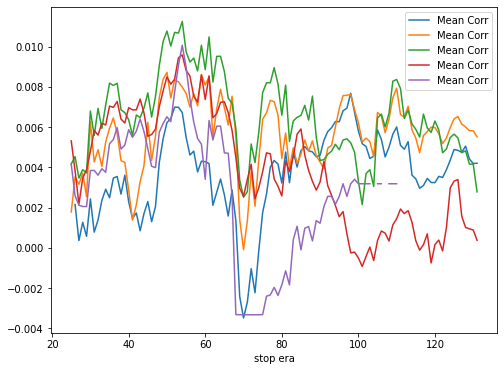

In [38]:
plt_rslt = results_summary
plt_rslt.groupby(['alpha'])
#plt_rslt.unstack(level = 'alpha')

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
bp = plt_rslt.groupby('alpha').plot('stop era', 'Mean Corr', ax=ax)


UsageError: Cell magic `%%R` not found.
